In [1]:
from tensorflow.keras.models import load_model
import cv2
from scipy.spatial import distance
import networkx as nx
import numpy as np
from keras import models, optimizers
from keras import layers, Input
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
model = models.Sequential()

model.add(Input(shape=(48,48,1)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(7, activation='softmax'))



model.compile(optimizer=optimizers.Adam(5e-5), loss='categorical_crossentropy', metrics=['accuracy'])


#SUMMARY
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,943 (1.22 MB)

 Trainable params: 319,943 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model.load_weights('Gabungan_model_32x150.weights.h5')

d:\KULIAH\Sem 8 Teknik Industri\Coding\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
# Read the image
image = cv2.imread('Dataset/Test/Crowd/Fullbody2/PPT Crowd 1/slide1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
face_images = []
face_centers = []

for (x, y, w, h) in faces:
    center_x = x + w // 2
    center_y = y + h // 2
    face_centers.append((center_x, center_y))

    face = gray[y:y+h, x:x+w]  # Extract the face in grayscale
    face = cv2.resize(face, (48, 48))  # Resize to 48x48
    face = face / 255.0  # Normalize pixel values to [0, 1]
    face = np.expand_dims(face, axis=-1)  # Add channel dimension, (48, 48, 1)
    face_images.append(face)

face_images = np.array(face_images)

# Predict the emotions
if len(face_images) > 0:
    predictions = model.predict(face_images)
    expressions = ['angry', 'disgust', 'fear', 'happy','neutral', 'sad', 'surprise']  # Example labels
    predicted_emotions = [expressions[np.argmax(pred)] for pred in predictions]

     # Visualize the results
    for (x, y, w, h), emotion in zip(faces, predicted_emotions):
        fontScale = 1  # Increase the font size
        fontThickness = 3  # Increase the thickness of the font
        cv2.putText(image, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (36, 255, 12), fontThickness)
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    # Calculate distances and create the graph
    G = nx.Graph()
    for i in range(len(face_centers)):
        G.add_node(i)
    
    for i in range(len(face_centers)):
        for j in range(i + 1, len(face_centers)):
            dist = distance.euclidean(face_centers[i], face_centers[j])
            G.add_edge(i, j, weight=dist)

    # Compute the Minimum Spanning Tree
    mst = nx.minimum_spanning_tree(G)

    # Draw the MST lines
    for edge in mst.edges(data=True):
        pt1 = face_centers[edge[0]]
        pt2 = face_centers[edge[1]]
        cv2.line(image, pt1, pt2, (0, 255, 0), 2)  # Draw lines between faces in MST
else:
    print("No faces detected.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


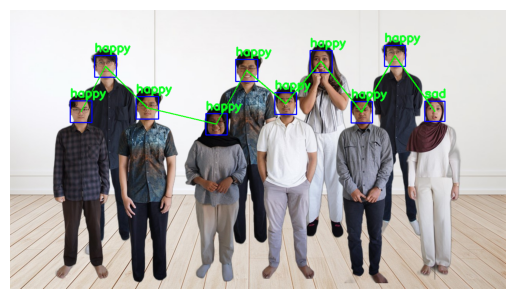

In [17]:
import matplotlib.pyplot as plt
# Convert BGR to RGB for displaying using matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show the image with the predicted emotions
plt.imshow(image_rgb)
plt.axis('off')  # Hide axis
plt.show()

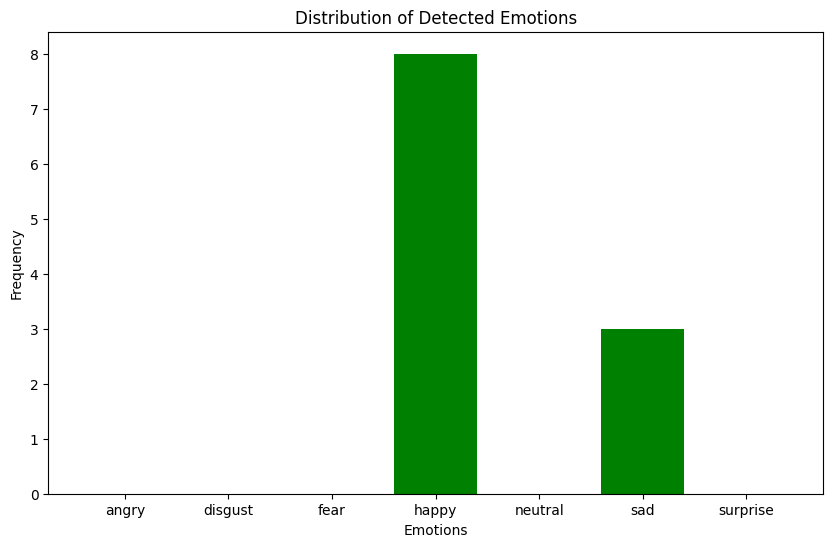

In [7]:
# Hitung frekuensi setiap ekspresi
expression_counts = {expression: predicted_emotions.count(expression) for expression in expressions}

# Buat diagram batang
plt.figure(figsize=(10, 6))
plt.bar(expression_counts.keys(), expression_counts.values(), color='green')

# Berikan judul dan label sumbu
plt.title('Distribution of Detected Emotions')
plt.xlabel('Emotions')
plt.ylabel('Frequency')

# Tampilkan diagram batang
plt.show()


In [8]:
model.load_weights('Gabungan_model_32x150.weights.h5')

In [14]:
# Open the video file
video_capture = cv2.VideoCapture("Dataset/Test/Crowd/Video/YT.mp4")

# Load the face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize a counter to collect the overall emotion distribution
overall_emotion_counts = Counter()

while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Prepare faces for CNN input and calculate face centers
    face_images = []
    face_centers = []

    for (x, y, w, h) in faces:
        center_x = x + w // 2
        center_y = y + h // 2
        face_centers.append((center_x, center_y))

        face = gray[y:y+h, x:x+w]  # Extract the face in grayscale
        face = cv2.resize(face, (48, 48))  # Resize to 48x48
        face = face / 255.0  # Normalize pixel values to [0, 1]
        face = np.expand_dims(face, axis=-1)  # Add channel dimension, (48, 48, 1)
        face_images.append(face)

    face_images = np.array(face_images)

    # Predict the emotions
    if len(face_images) > 0:
        predictions = model.predict(face_images)
        expressions = ['angry', 'disgust', 'fear', 'happy','neutral', 'sad', 'surprise']  # Example labels
        predicted_emotions = [expressions[np.argmax(pred)] for pred in predictions]

        # Update the overall emotion counts
        overall_emotion_counts.update(predicted_emotions)
        
        # Visualize the results
        for (x, y, w, h), emotion in zip(faces, predicted_emotions):
            fontScale = 1.5  # Increase the font size
            fontThickness = 3  # Increase the thickness of the font
            cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (36, 255, 12), fontThickness)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Calculate distances and create the graph
        G = nx.Graph()
        for i in range(len(face_centers)):
            G.add_node(i)

        for i in range(len(face_centers)):
            for j in range(i + 1, len(face_centers)):
                dist = distance.euclidean(face_centers[i], face_centers[j])
                G.add_edge(i, j, weight=dist)

        # Compute the Minimum Spanning Tree
        mst = nx.minimum_spanning_tree(G)

        # Draw the MST lines
        for edge in mst.edges(data=True):
            pt1 = face_centers[edge[0]]
            pt2 = face_centers[edge[1]]
            cv2.line(frame, pt1, pt2, (0, 255, 0), 2)  # Draw lines between faces in MST

        # Plotting a bar chart of emotion distribution
        emotion_counts = Counter(predicted_emotions)
        plt.figure(figsize=(5, 3))
        plt.bar(emotion_counts.keys(), emotion_counts.values(), color='green')
        plt.xlabel('Emotions')
        plt.ylabel('Count')
        plt.title('Emotion Distribution in Frame')
        plt.tight_layout()

        # Convert the plot to an image and overlay on video
        plt.draw()
        plot_image = np.frombuffer(plt.gcf().canvas.tostring_rgb(), dtype=np.uint8)
        plot_image = plot_image.reshape(plt.gcf().canvas.get_width_height()[::-1] + (3,))
        plt.close()

        # Resize plot image to fit in the video frame
        plot_image = cv2.resize(plot_image, (frame.shape[1] // 3, frame.shape[0] // 3))

        # Calculate the position for the bottom right corner
        start_y = frame.shape[0] - plot_image.shape[0]  # Vertical position (bottom)
        start_x = frame.shape[1] - plot_image.shape[1]  # Horizontal position (right)

        # Position the plot image on the bottom right corner of the video frame
        frame[start_y:frame.shape[0], start_x:frame.shape[1]] = plot_image

    # Display the resulting frame
    cv2.imshow('Video', frame)

    # Break the loop when 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all OpenCV windows
video_capture.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


C:\Users\windows 10\AppData\Local\Temp\ipykernel_11400\1375427913.py:83: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  plot_image = np.frombuffer(plt.gcf().canvas.tostring_rgb(), dtype=np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━

Overall Emotion Distribution:
sad: 309
happy: 1794


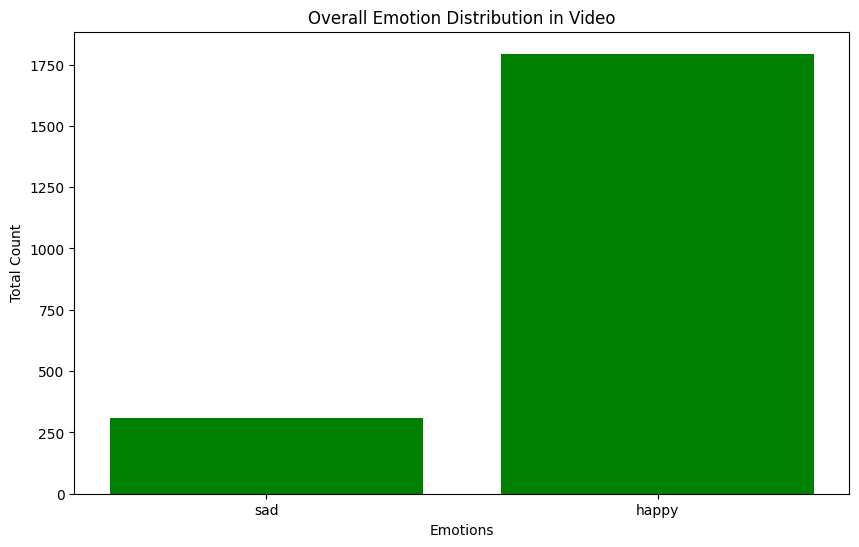

In [15]:
# Print the overall emotion summary
print("Overall Emotion Distribution:")
for emotion, count in overall_emotion_counts.items():
    print(f"{emotion}: {count}")

# Optionally, you can save the summary to a file
with open('emotion_summary.txt', 'w') as f:
    for emotion, count in overall_emotion_counts.items():
        f.write(f"{emotion}: {count}\n")
        

# Plot the overall emotion distribution
emotions = list(overall_emotion_counts.keys())
counts = list(overall_emotion_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(emotions, counts, color="green")
plt.xlabel('Emotions')
plt.ylabel('Total Count')
plt.title('Overall Emotion Distribution in Video')
plt.show()